# Portfolio Assignment week 03 

This week's focus is on anomaly detection. As part of the portfolio assignment, you are required to make a contribution using anomaly detection algorithm(s). There are several options for your contribution, so you can choose the one that aligns with your learning style or interests the most

## Anomaly Detection

Anomaly detection in machine learning refers to the process of identifying patterns or instances in a dataset that deviate significantly from the norm or expected behavior. Anomalies, also known as outliers, are data points that are rare, unusual, or don't conform to the typical patterns observed in the majority of the data. Anomaly detection algorithms aim to automatically detect these anomalies. Anomaly detection in machine learning has various applications across domains, including predictive maintenance, and healthcare monitoring. By automatically identifying anomalies, these algorithms help in detecting potential risks. 


## Anomaly Detection Assignment

Study the notebook `Study_Case_Anomoly_Detection` 

Choose at least 1 out of the listed assignments below

- Analyze the end result plot to evaluate the algorithm's performance. Look for anomalies identified by the algorithm and compare them to known anomalies or instances of abnormal behavior in the data. Assess whether the algorithm successfully captures these anomalies and if it shows promising results in detecting abnormal patterns. Based on the plot analysis, provide argumentation for the validity of the anomaly detection algorithm hypothesis (see above). Discuss how the algorithm effectively captures anomalies in the time series data and why it is a suitable approach for the use case. Support your argument with references to relevant literature that discuss the effectiveness of the chosen algorithm or similar algorithms in detecting anomalies in time series data.
- To improve data quality for anomaly detection in time series data, we can focus on removing outliers due to sensor reading errors while preserving anomalies. Additionally, performing resampling or aggregation can help reduce noise and highlight higher-level patterns relevant for anomaly detection. Find common steps to improve data quality for this particular use and implement those. Evaluate the performance of the algorithms compare to the original notebook.
- Try another algorithm that has not been tested in the notebook. Provide argumentation for the validity of the anomaly detection algorithm you choose.
- Try to find the best configuration for one of the tested algorithms
- Try anomaly detection on a different dataset without timeseries data. Intrepret the results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [3]:
# source: https://www.kaggle.com/datasets/nphantawee/pump-sensor-data
df_sensor = pd.read_csv('datasets_DS3\\sensor.csv').drop('Unnamed: 0', axis=1)
df_origin = df_sensor.copy()

In [4]:
df_sensor.shape

(220320, 54)

In [5]:
df_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

In [6]:
df_sensor.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [7]:
#missing values
percentage_missing = df_sensor.isnull().sum().sort_values(ascending=False)/len(df_sensor)*100
percentage_missing.head(10) # show 10 largest missing %

sensor_15    100.000000
sensor_50     34.956881
sensor_51      6.982117
sensor_00      4.633261
sensor_07      2.474129
sensor_08      2.317992
sensor_06      2.177741
sensor_09      2.085603
sensor_01      0.167484
sensor_30      0.118464
dtype: float64

In [8]:
# drop low quality columns
df_sensor.drop(['sensor_15', 'sensor_50'],inplace = True,axis=1)
# set timestamp to date
df_sensor['timestamp'] = pd.to_datetime(df_sensor['timestamp'])
df_sensor_set = df_sensor.set_index('timestamp')

In [9]:
# This visualization inspired from JANANI KARIYAWASAM found at 
# https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering
broken_rows = df_sensor_set[df_sensor_set['machine_status']=='BROKEN']
recovery_rows = df_sensor_set[df_sensor_set['machine_status']=='RECOVERING']
normal_rows = df_sensor_set[df_sensor_set['machine_status']=='NORMAL']

def plot_sensor(sensor):
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering')
    plot = plt.plot(df_sensor_set[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=14, label = 'broken')
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show();

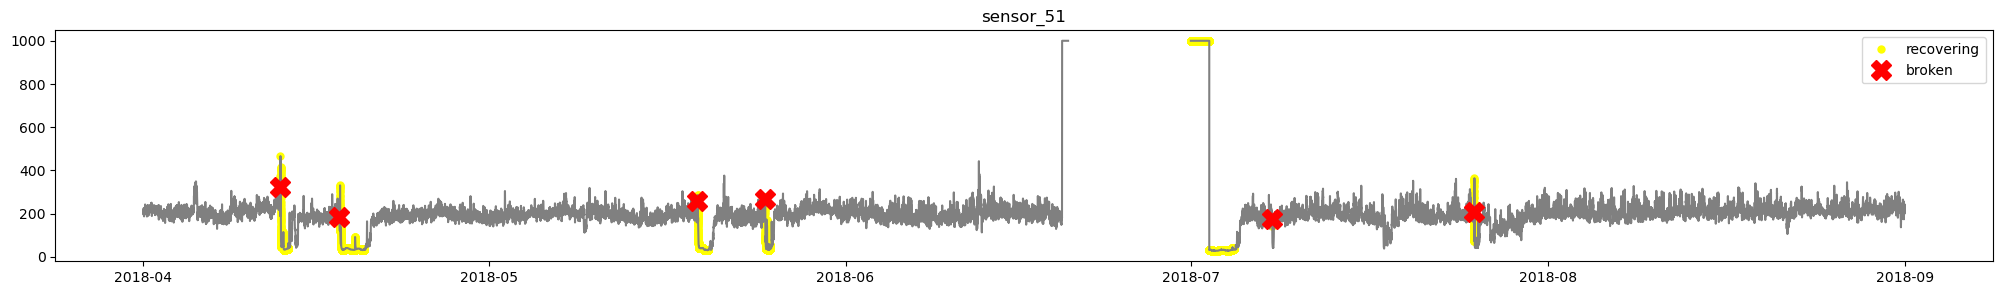

In [10]:
# plot sensor 51
plot_sensor('sensor_51')

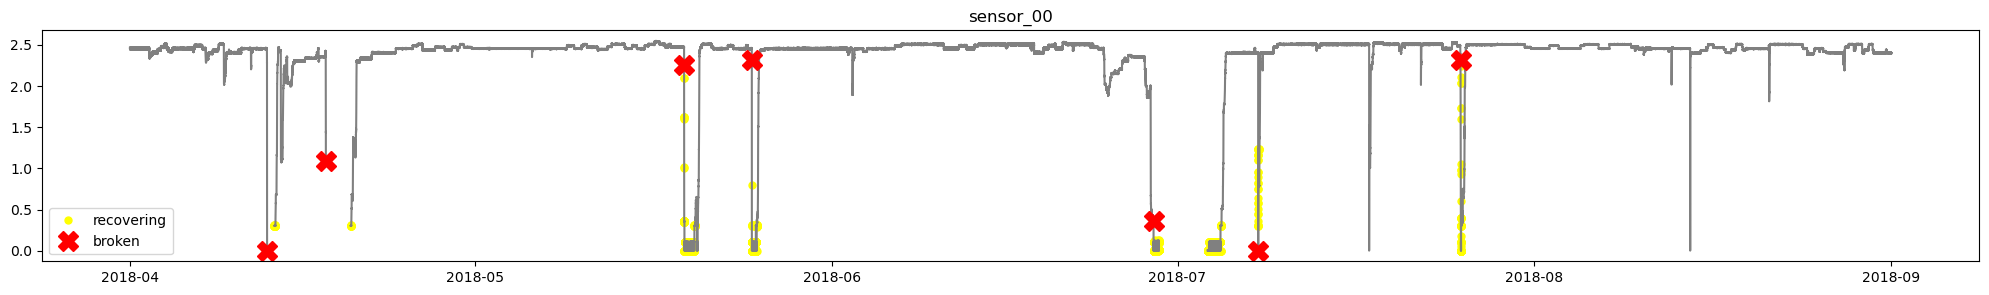

In [11]:
plot_sensor('sensor_00')

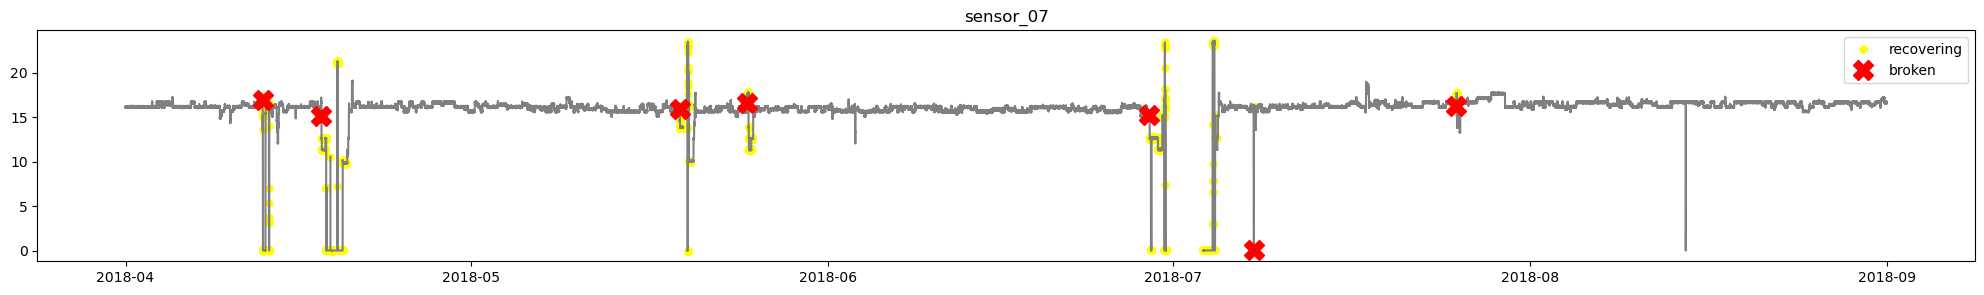

In [12]:
plot_sensor('sensor_07')

### The code used above is taken from: https://github.com/fenna/BFVM23DATASCNC5/blob/main/Study_Cases/Study_Case_Anomaly_Detection.ipynb

----

## Preparation for machine learning (Anomaly detection)

In [14]:
# use mean of the column to handle missing values and remove label in feature matrix X
m, n = df_sensor_set.shape
X = df_sensor_set.iloc[:,:n-1] # ignore machine status columns
X = X.fillna(X.mean())
X.shape

(220320, 50)

In [15]:
# specify the columns with anomalies
sensor_columns = ['sensor_51', 'sensor_00', 'sensor_07'] 

# Extract the specified columns from the DataFrame
sensor_model_df = df_sensor_set[sensor_columns]

In [16]:
sensor_model_df.reset_index(inplace=True)
sensor_model_df.fillna(0,inplace=True)
sensor_model_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_26304\771966521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df.fillna(0,inplace=True)


,timestamp,sensor_51,sensor_00,sensor_07
0,2018-04-01 00:00:00,201.3889,2.465394,16.13136
1,2018-04-01 00:01:00,201.3889,2.465394,16.13136
2,2018-04-01 00:02:00,203.7037,2.444734,16.03733
3,2018-04-01 00:03:00,203.1250,2.460474,16.24711
4,2018-04-01 00:04:00,201.3889,2.445718,16.21094


In [17]:
print(sensor_model_df.dtypes)

timestamp    datetime64[ns]
sensor_51           float64
sensor_00           float64
sensor_07           float64
dtype: object


### Converting the timestamp to a categorical datetime

In [18]:
# the hours and if it's night or day (7:00-22:00)
sensor_model_df['hours'] = sensor_model_df['timestamp'].dt.hour
sensor_model_df['daylight'] = ((sensor_model_df['hours'] >= 7) & (sensor_model_df['hours'] <= 22)).astype(int)

C:\Users\User\AppData\Local\Temp\ipykernel_26304\2158095965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['hours'] = sensor_model_df['timestamp'].dt.hour
C:\Users\User\AppData\Local\Temp\ipykernel_26304\2158095965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['daylight'] = ((sensor_model_df['hours'] >= 7) & (sensor_model_df['hours'] <= 22)).astype(int)


In [19]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
sensor_model_df['DayOfTheWeek'] = sensor_model_df['timestamp'].dt.dayofweek
sensor_model_df['WeekDay'] = (sensor_model_df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

C:\Users\User\AppData\Local\Temp\ipykernel_26304\324990231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['DayOfTheWeek'] = sensor_model_df['timestamp'].dt.dayofweek
C:\Users\User\AppData\Local\Temp\ipykernel_26304\324990231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['WeekDay'] = (sensor_model_df['DayOfTheWeek'] < 5).astype(int)


In [20]:
# time with int to plot easily
sensor_model_df['time_epoch'] = (sensor_model_df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

C:\Users\User\AppData\Local\Temp\ipykernel_26304\1058787590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['time_epoch'] = (sensor_model_df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)


### Checking the categories of the date time for 'sensor 51'

C:\Users\User\AppData\Local\Temp\ipykernel_26304\2920902841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['categories'] = sensor_model_df['WeekDay']*2 + sensor_model_df['daylight']


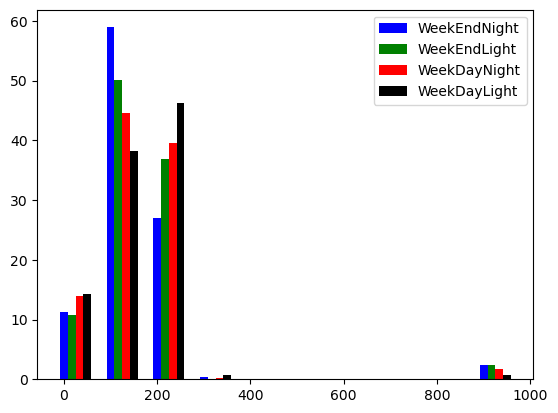

In [21]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
sensor_model_df['categories'] = sensor_model_df['WeekDay']*2 + sensor_model_df['daylight']

a = sensor_model_df.loc[sensor_model_df['categories'] == 0, 'sensor_51']
b = sensor_model_df.loc[sensor_model_df['categories'] == 1, 'sensor_51']
c = sensor_model_df.loc[sensor_model_df['categories'] == 2, 'sensor_51']
d = sensor_model_df.loc[sensor_model_df['categories'] == 3, 'sensor_51']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

---

## Different models used to detect anomalies

#### The use of clustering method (k-means) aim to group similar data points together into clusters. In anomaly detection, the idea is to assume that normal data points should naturally form clusters, and outliers or anomalies will be far from these clusters. In which, can be more interpretable since it provides information about which data points belong to which cluster. This can help in understanding the characteristics of normal data and identifying anomalies as points that do not belong to any cluster or belong to small or isolated clusters. however, it can be computationally expensive, especially with large datasets, as it often involves calculating distances between data points. However, there are scalable clustering algorithms available for handling big data. Moreover, clustering is particularly useful when you expect anomalies to be rare and not well-defined in advance. It can adapt to different types of anomalies, including those that are not known beforehand. In this case, we use the dataset from reading sensors for determining the method and its performance

### Applying Cluster only for the column 'sensor_51'

In [23]:
# Take useful feature and standardize them
data = sensor_model_df[['sensor_51', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_k

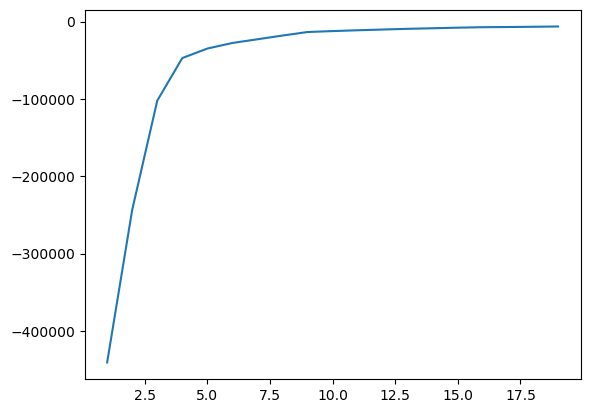

In [24]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [25]:
# Not clear for me, 15 centroids are chosen arbitrarily and add these data to the central dataframe
sensor_model_df['cluster'] = kmeans[14].predict(data)
sensor_model_df['principal_feature1'] = data[0]
sensor_model_df['principal_feature2'] = data[1]
sensor_model_df['cluster'].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_26304\4215980707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['cluster'] = kmeans[14].predict(data)
C:\Users\User\AppData\Local\Temp\ipykernel_26304\4215980707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['principal_feature1'] = data[0]
C:\Users\User\AppData\Local\Temp\ipykernel_26304\4215980707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

2     18480
3     18060
10    17216
14    17160
1     17160
9     15720
8     15540
0     15420
12    14520
11    14404
4     13200
13    12900
5     12000
7      9300
6      9240
Name: cluster, dtype: int64

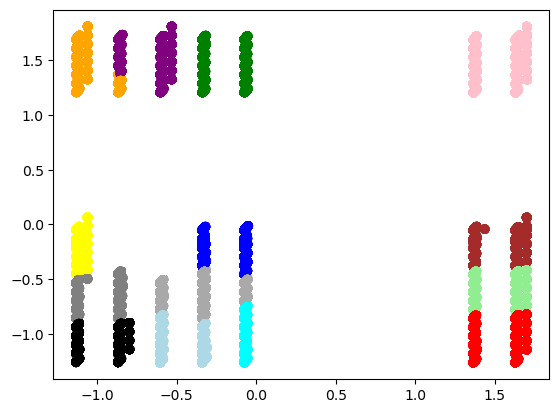

In [26]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(sensor_model_df['principal_feature1'], sensor_model_df['principal_feature2'], c=sensor_model_df["cluster"].apply(lambda x: colors[x]))
plt.show()

### Function used for getting the distance between each data point

In [27]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa - Xb)
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [28]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
sensor_model_df['anomaly21'] = (distance >= threshold).astype(int)

C:\Users\User\AppData\Local\Temp\ipykernel_26304\266898665.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()
C:\Users\User\AppData\Local\Temp\ipykernel_26304\1690141756.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['anomaly21'] = (distance >= threshold).astype(int)


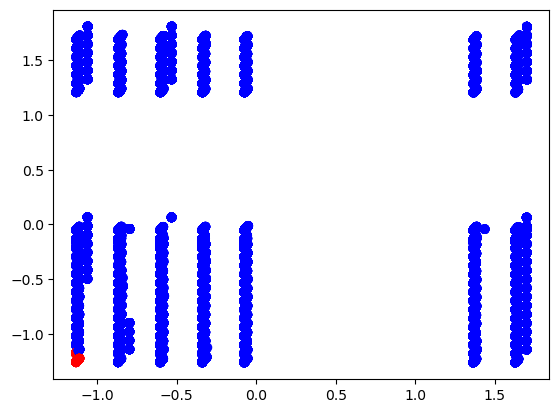

In [29]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(sensor_model_df['principal_feature1'], sensor_model_df['principal_feature2'], c=sensor_model_df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

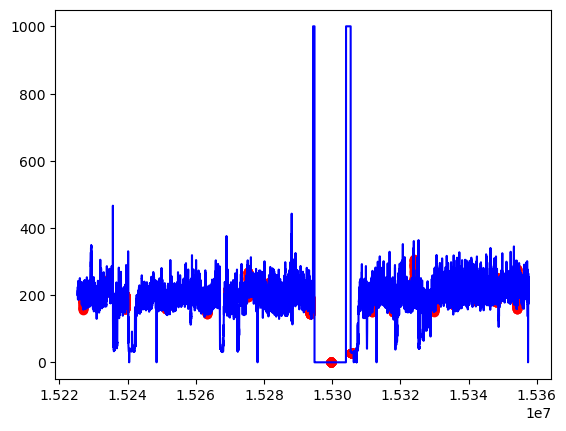

In [30]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = sensor_model_df.loc[sensor_model_df['anomaly21'] == 1, ['time_epoch', 'sensor_51']] #anomaly

ax.plot(sensor_model_df['time_epoch'], sensor_model_df['sensor_51'], color='blue')
ax.scatter(a['time_epoch'],a['sensor_51'], color='red')
plt.show()

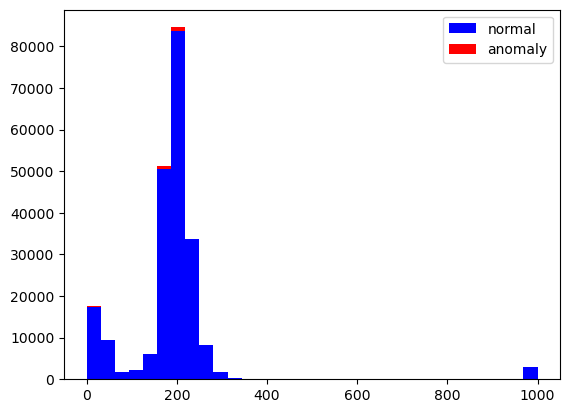

In [31]:
a = sensor_model_df.loc[sensor_model_df['anomaly21'] == 0, 'sensor_51']
b = sensor_model_df.loc[sensor_model_df['anomaly21'] == 1, 'sensor_51']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [32]:
# creation of 4 differents data set based on categories defined before
df_class0 = sensor_model_df.loc[sensor_model_df['categories'] == 0, 'sensor_51']
df_class1 = sensor_model_df.loc[sensor_model_df['categories'] == 1, 'sensor_51']
df_class2 = sensor_model_df.loc[sensor_model_df['categories'] == 2, 'sensor_51']
df_class3 = sensor_model_df.loc[sensor_model_df['categories'] == 3, 'sensor_51']

C:\Users\User\AppData\Local\Temp\ipykernel_26304\647217440.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_class0.hist(ax=axs[0,0],bins=20)
C:\Users\User\AppData\Local\Temp\ipykernel_26304\647217440.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_class1.hist(ax=axs[0,1],bins=20)
C:\Users\User\AppData\Local\Temp\ipykernel_26304\647217440.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_class2.hist(ax=axs[1,0],bins=20)
C:\Users\User\AppData\Local\Temp\ipykernel_26304\647217440.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_class3.hist(ax=axs[1,1],bins=20)


array([[<Axes: title={'center': 'sensor_51'}>,
        <Axes: title={'center': 'deviation'}>],
       [<Axes: title={'center': 'anomaly'}>, <Axes: >]], dtype=object)

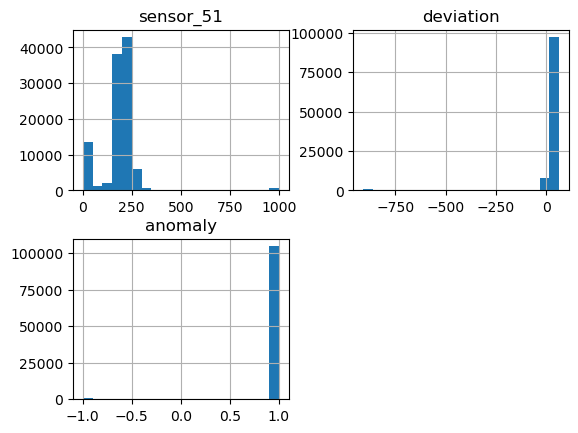

In [46]:
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=20)
df_class1.hist(ax=axs[0,1],bins=20)
df_class2.hist(ax=axs[1,0],bins=20)
df_class3.hist(ax=axs[1,1],bins=20)

C:\Users\User\AppData\Local\Temp\ipykernel_26304\3734504507.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_class0.hist(ax=axs[0, 0], bins=20, color='blue', alpha=0.7)
C:\Users\User\AppData\Local\Temp\ipykernel_26304\3734504507.py:14: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_class1.hist(ax=axs[0, 1], bins=20, color='green', alpha=0.7)
C:\Users\User\AppData\Local\Temp\ipykernel_26304\3734504507.py:17: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_class2.hist(ax=axs[1, 0], bins=20, color='red', alpha=0.7)
C:\Users\User\AppData\Local\Temp\ipykernel_26304\3734504507.py:20: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_class3.hist(ax=axs[1, 1], bins=20, color='purple', alpha=0.7)


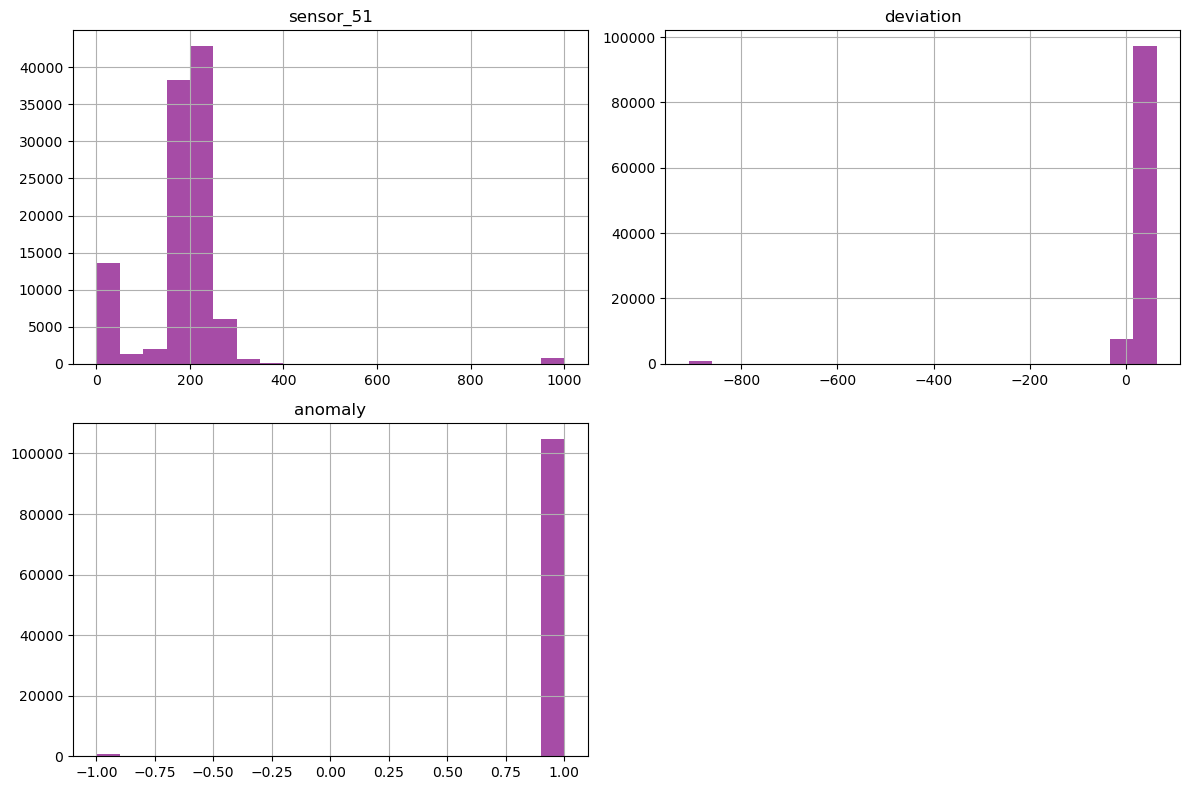

In [45]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Adjust the figsize as needed

# Plot histograms with titles and improved formatting
df_class0.hist(ax=axs[0, 0], bins=20, color='blue', alpha=0.7)
axs[0, 0].set_title("Class 0", fontsize=14, fontweight='bold')

df_class1.hist(ax=axs[0, 1], bins=20, color='green', alpha=0.7)
axs[0, 1].set_title("Class 1", fontsize=14, fontweight='bold')

df_class2.hist(ax=axs[1, 0], bins=20, color='red', alpha=0.7)
axs[1, 0].set_title("Class 2", fontsize=14, fontweight='bold')

df_class3.hist(ax=axs[1, 1], bins=20, color='purple', alpha=0.7)
axs[1, 1].set_title("Class 3", fontsize=14, fontweight='bold')

# Add some space between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [41]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

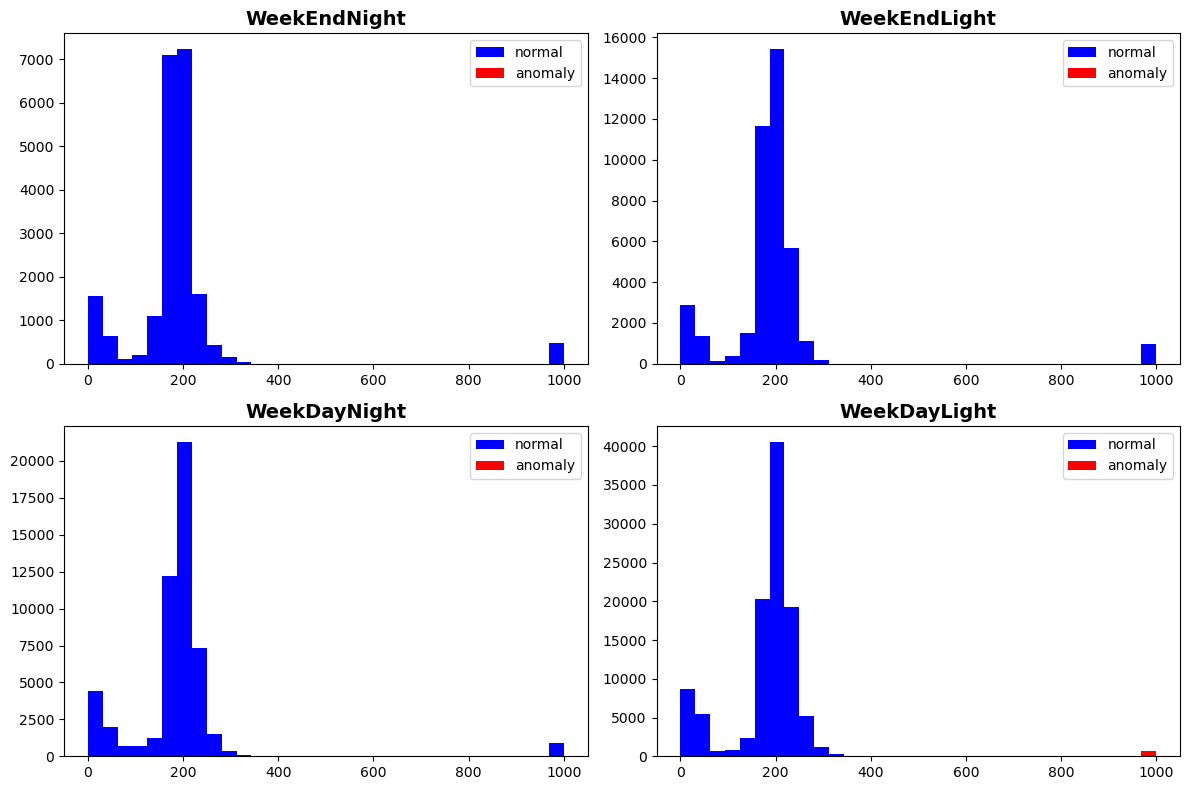

In [53]:
# plot the sensor 51 readings repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'sensor_51']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'sensor_51']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'sensor_51']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'sensor_51']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'sensor_51']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'sensor_51']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'sensor_51']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'sensor_51']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Adjust the figsize as needed

# Plot histograms with titles and improved formatting
axs[0, 0].hist([a0, b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0, 0].set_title("WeekEndNight", fontsize=14, fontweight='bold')
axs[0, 0].legend()

axs[0, 1].hist([a1, b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0, 1].set_title("WeekEndLight", fontsize=14, fontweight='bold')
axs[0, 1].legend()

axs[1, 0].hist([a2, b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1, 0].set_title("WeekDayNight", fontsize=14, fontweight='bold')
axs[1, 0].legend()

axs[1, 1].hist([a3, b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1, 1].set_title("WeekDayLight", fontsize=14, fontweight='bold')
axs[1, 1].legend()

# Add some space between subplots
plt.tight_layout()

# Display the plot
plt.show()

#### In the four graphs above, the last graph which represents the anomaly in red bar at the end of the graph (which is far from the normal reading for the sensor), this suggest a sudden spike from the error reading from the sensor during the day of the weekday. 

#### The second method for anomaly detection is Isolation Forest, it is an ensemble-based anomaly detection algorithm that works by isolating anomalies in the dataset using binary decision trees. It's effective at isolating anomalies because it doesn't need to form clusters like clustering methods. Isolation Forest is often more computationally efficient than clustering methods, especially when dealing with large datasets. It can efficiently identify anomalies by recursively splitting the data. Moreover, Isolation Forest does not require you to specify the number of clusters or other parameters like distance thresholds. It automatically identifies anomalies as data points that can be isolated with fewer splits in the tree and that Isolation Forest is known for its scalability, making it suitable for large-scale datasets with high-dimensional features. Thus, Isolation Forest is particularly useful when you have a large dataset, and you want a computationally efficient method for detecting anomalies without the need for extensive parameter tuning. It's also suitable when anomalies are expected to be isolated or exhibit different patterns from normal data. In our case, the dataset is suitable for this method, because it is a larger dataset

### Applying IsolationForest to detect anomalies in the dataset for column 'sensor_51'

In [50]:
# Take useful feature and standardize them 
data = sensor_model_df[['sensor_51', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
sensor_model_df['anomaly25'] = pd.Series(model.predict(data))
sensor_model_df['anomaly25'] = sensor_model_df['anomaly25'].map( {1: 0, -1: 1} )
print(sensor_model_df['anomaly25'].value_counts())

0    218128
1      2192
Name: anomaly25, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_26304\2989043507.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['anomaly25'] = pd.Series(model.predict(data))
C:\Users\User\AppData\Local\Temp\ipykernel_26304\2989043507.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_model_df['anomaly25'] = sensor_model_df['anomaly25'].map( {1: 0, -1: 1} )


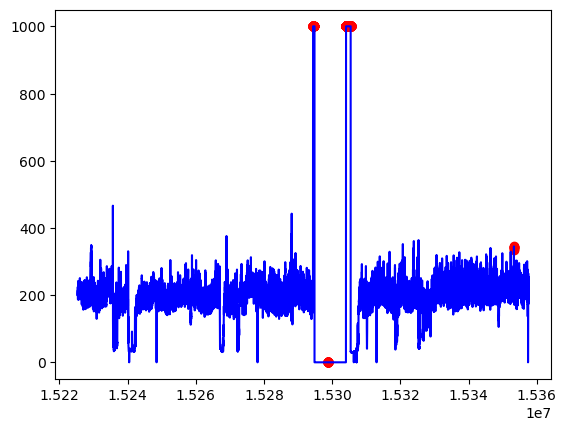

In [51]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = sensor_model_df.loc[sensor_model_df['anomaly25'] == 1, ['time_epoch', 'sensor_51']] #anomaly

ax.plot(sensor_model_df['time_epoch'], sensor_model_df['sensor_51'], color='blue')
ax.scatter(a['time_epoch'],a['sensor_51'], color='red')
plt.show()

#### As seen in the graph above, the anomalies are shown in red dots for the column sensor 51. The most noticable anomalies are found within the range (line) where it drops and suddenly spikes up and down with not normal values. The last anomaly is found somewhere near the end of the reading of sensor graph.

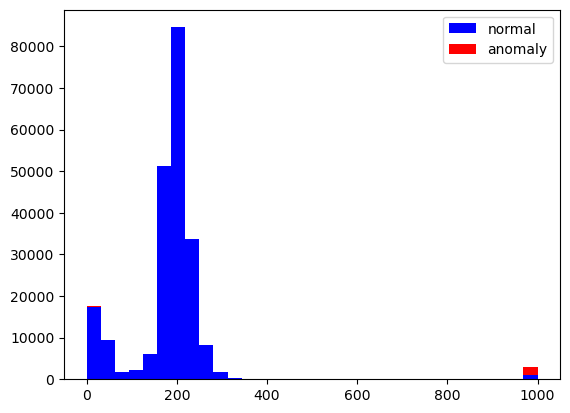

In [52]:
a = sensor_model_df.loc[sensor_model_df['anomaly25'] == 0, 'sensor_51']
b = sensor_model_df.loc[sensor_model_df['anomaly25'] == 1, 'sensor_51']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

#### In the graph above is seen that the anomalies are found at the beginning (near the zero and 50) and all the way at the end of the reading at 1000

#### The above methods for anomaly detection can also be applied for the other columns separately (sensors 00 and 07) of the dataset.  

### The codes above are taken from: https://www.kaggle.com/code/victorambonati/unsupervised-anomaly-detection

---

### Other methods or models to detect anomalies

In [57]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X= scaler.fit_transform(X)

In [58]:
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.utils.example import visualize

In [59]:
X_1 = df_sensor_set.drop('machine_status', axis=1)
y_1= df_sensor_set['machine_status']

In [60]:
# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_imputed = imputer.fit_transform(X_1)

In [61]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_1, test_size=0.2, random_state=42)

In [62]:
from sklearn.cluster import DBSCAN
outlier = DBSCAN(
  eps = 0.5,
  metric="euclidean",
  min_samples = 3,
  n_jobs = -1)
clusters = outlier.fit_predict(X)
clusters 


array([   -1,    -1,    -1, ..., 16516, 16516, 16516], dtype=int64)

In [63]:
value=-1
index = clusters.argmin()
print(" The element is at ", index)
small_num = np.min(clusters)
print("The small number is : " , small_num)
print(np.where(clusters == small_num))

 The element is at  0
The small number is :  -1
(array([     0,      1,      2, ..., 220311, 220312, 220313], dtype=int64),)


In [65]:
# Create a DataFrame with column names
df_sensor_set_1 = pd.DataFrame(columns=['machine_status', 'sensor_51', 'sensor_00', 'sensor_07'])

# Perform the operation on the 'sensor_51', 'sensor_00', and 'sensor_07' columns
df_sensor_set_1[['sensor_51', 'sensor_00', 'sensor_07']] = np.where(
    (df_sensor_set_1[['sensor_51', 'sensor_00', 'sensor_07']] != 0),
    np.log(df_sensor_set_1[['sensor_51', 'sensor_00', 'sensor_07']]),
    0
)

In [66]:
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

#### The ECOD (Extended CO-Evolutionary Outlier Detection) detector is a machine learning-based anomaly detection algorithm. It was designed to address the challenges of anomaly detection in high-dimensional data, where traditional methods often struggle due to the curse of dimensionality. ECOD was introduced as a solution to improve the accuracy and efficiency of anomaly detection in such datasets.
#### ECOD operates on the principle of co-evolution. It simultaneously evolves two populations of solutions: one for modeling the distribution of normal data and the other for modeling the distribution of anomalies.
#### ECOD uses kernel density estimation (KDE) to model the probability density functions (PDFs) of normal data and anomalies separately. KDE is a non-parametric technique that estimates the probability density function of a dataset.
#### One of the key features of ECOD is its adaptive bandwidth selection for KDE. It automatically adapts the bandwidth (a crucial parameter in KDE) for each dimension based on the characteristics of the data. This adaptability helps in capturing the shape of the data distribution effectively.
#### ECOD assigns an outlier score to each data point based on the likelihood of it being an anomaly. This score is calculated by comparing the data point's PDF value in the normal population to its PDF value in the anomaly population. If a point has a significantly higher PDF value in the anomaly population, it's considered more likely to be an anomaly.
#### To improve robustness and reduce the risk of overfitting, ECOD employs an ensemble approach. It trains multiple ECOD detectors with random subsets of the data and combines their results to provide a final anomaly score.
#### In summary, the ECOD detector is a co-evolutionary outlier detection algorithm that excels in high-dimensional data by using adaptive kernel density estimation and an ensemble of detectors. Its adaptability, scalability, and robustness make it a useful tool for detecting anomalies in complex datasets, especially when the dimensionality of the data is a challenge for traditional methods.

In [67]:
# train an ECOD detector
from pyod.models.ecod import ECOD
clf = ECOD()
clf.fit(X_train)

# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
y_test_scores = clf.decision_function(X_test)  # predict raw outlier scores on test

In [68]:
# train ECOD detector
clf_name = 'ECOD'
clf = ECOD()

In [69]:
 # you could try parallel version as well.
# clf = ECOD(n_jobs=2)
clf.fit(X_train)

ECOD(contamination=0.1, n_jobs=1)

In [70]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [71]:
# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores


In [72]:
# evaluate and print the results
from pyod.utils.data import evaluate_print
print("\nOn Training Data:")
print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
print(clf_name, y_test, y_test_scores)



On Training Data:
ECOD timestamp
2018-04-13 21:59:00        NORMAL
2018-05-28 00:18:00        NORMAL
2018-07-09 00:11:00        NORMAL
2018-06-05 16:27:00        NORMAL
2018-04-23 01:37:00        NORMAL
                          ...    
2018-06-23 05:59:00        NORMAL
2018-06-12 00:14:00        NORMAL
2018-07-01 14:52:00    RECOVERING
2018-07-11 23:47:00        NORMAL
2018-06-24 16:38:00        NORMAL
Name: machine_status, Length: 176256, dtype: object [ 75.18035609  68.90515003  72.17806542 ... 123.05246456  76.55529831
  81.76438229]

On Test Data:
ECOD timestamp
2018-06-15 02:25:00        NORMAL
2018-08-08 00:59:00        NORMAL
2018-07-14 14:48:00        NORMAL
2018-08-29 14:38:00        NORMAL
2018-08-17 18:13:00        NORMAL
                          ...    
2018-05-21 05:49:00        NORMAL
2018-07-02 09:11:00    RECOVERING
2018-06-07 15:14:00        NORMAL
2018-05-12 06:29:00        NORMAL
2018-07-19 10:43:00        NORMAL
Name: machine_status, Length: 44064, dtype: object 

### The code above was taken from: https://github.com/yzhao062/pyod/blob/master/examples/ecod_example.py

In [84]:
################### Train Isolation Forest #################
from sklearn.ensemble import IsolationForest
data_anom = sensor_model_df[['sensor_51', 'sensor_00', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
model  = IsolationForest(n_estimators=50, max_samples=500, contamination=.01, max_features=2, 
                         bootstrap=False, n_jobs=1, random_state=1, verbose=0, warm_start=False).fit(data)
# Get Anomaly Scores and Predictions
anomaly_score = model.decision_function(data_anom)
predictions = model.predict(data_anom)

c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Contamination = 0.01')

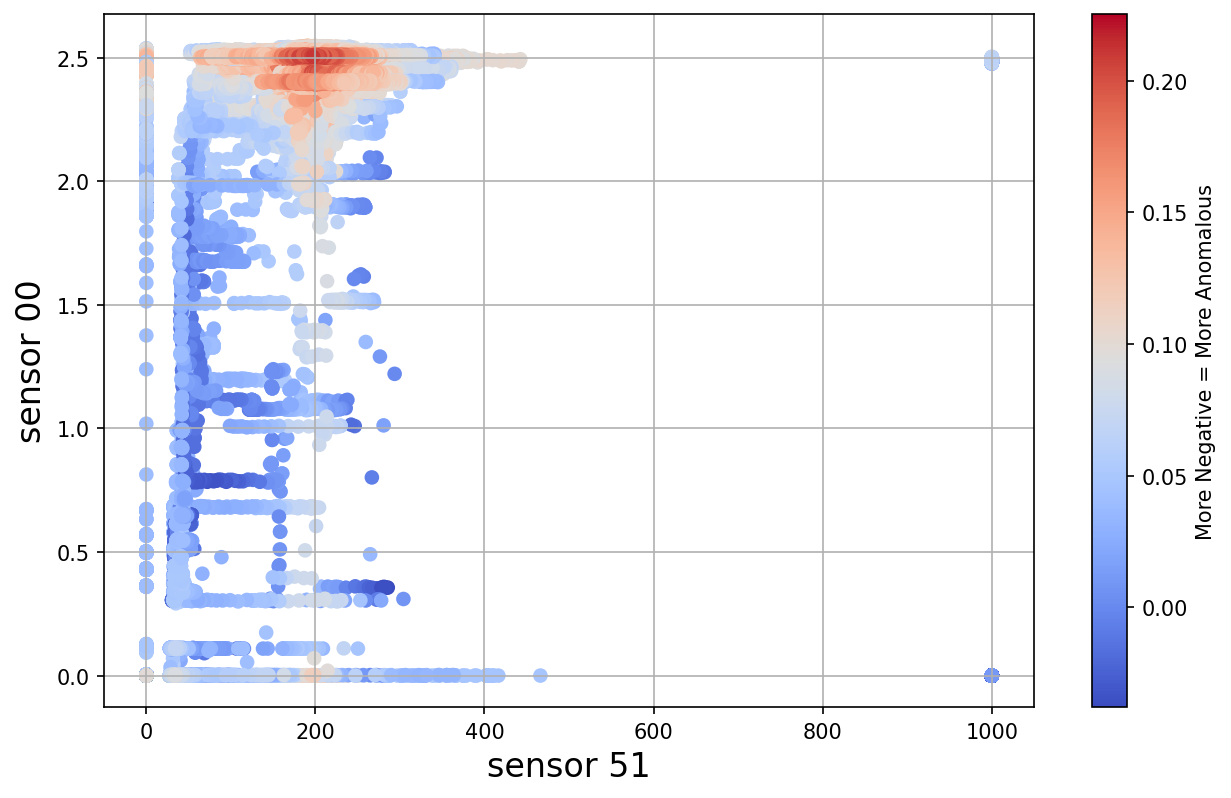

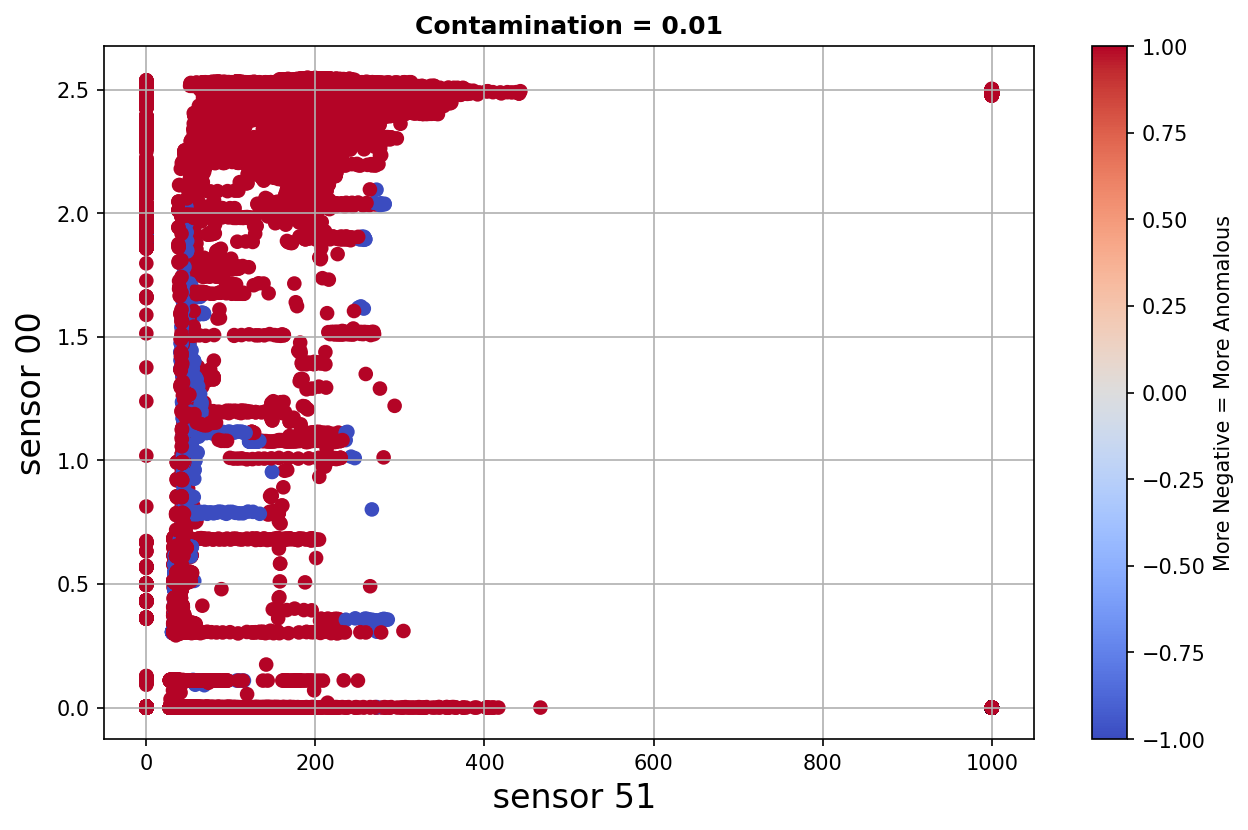

In [85]:
######### Visualize Anomaly scores and Anomaly Status ########
plt.figure(figsize = (10, 6), dpi = 150)
s = plt.scatter(data['sensor_51'], data['sensor_00'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel('sensor 51', fontsize = 16)
plt.ylabel('sensor 00', fontsize = 16)
plt.grid()
# To Plot Predictions
plt.figure(figsize = (10, 6), dpi = 150)
s = plt.scatter(data['sensor_51'], data['sensor_00'], c = predictions, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel(' sensor 51', fontsize = 16)
plt.ylabel('sensor 00', fontsize = 16)
plt.grid()
plt.title('Contamination = 0.01', weight = 'bold')

#### In the first graph, it is seen that the red dots are more concentrated in upper part and near the beginning of the reading, while the rest more spread out in blue and some red dots are found at the end of the reading.
#### In the second graph,  it can be seen that blue dots (anomaly datapoints) are considered to be more anomalous or are error readings from the sensor due to sudden spikes (low and high), while the the red dots (normal datapoints) are the normal readings from the sensors.

In [87]:
print(len(anomaly_score))

220320


In [90]:
my_array_sensor = np.array(data_anom)
print(my_array_sensor)

[[201.3889     2.465394   0.         0.         6.         0.      ]
 [201.3889     2.465394   0.         0.         6.         0.      ]
 [203.7037     2.444734   0.         0.         6.         0.      ]
 ...
 [232.0602     2.396528  23.         0.         4.         1.      ]
 [234.0856     2.406366  23.         0.         4.         1.      ]
 [234.0856     2.396528  23.         0.         4.         1.      ]]


In [93]:
from sklearn import svm

def plot_anomaly2(data, predicted, ax):
    sensor_model_df['sensor_51'] = predicted
    
    normal = data_anom.loc[data_anom['sensor_51'] == 1, :]
    anomalies = data_anom.loc[data_anom['sensor_51'] == -1, :]
    
    # Make Scatterplot
    column1 = data_anom.columns[0]
    column2 = data_anom.columns[1]
    
    
    anomalies.plot.scatter(column1, column2, color = 'tomato', fontsize = 14,  sharex = False, ax=ax)
    normal.plot.scatter(column1, column2, color = 'grey', fontsize = 14,  sharex = False, ax = ax)
    #plt.grid(linestyle = '--')
    
    plt.xlabel(column1, fontsize = 14, weight = 'bold')
    plt.ylabel(column2, fontsize = 14, weight = 'bold')
    return ax
    # Create Fake data to classify 
x_fake  =  pd.DataFrame(np.random.uniform(-5, 19, (35000, 2)), columns = ['Var 1', 'Var 2'])
# Visualize effect of changing Gamma
gammas = [.00005, .005, .01, .025, .05, .1,.3, .6, .9, 2, 5, 10]
fig, axes = plt.subplots(2, 6, figsize = (25, 6), tight_layout = True)
for i, ax in zip(range(len(gammas)), axes.flatten()):
    gamma = gammas[i]
    model = svm.OneClassSVM(kernel='rbf', degree=5, gamma=gamma, coef0=0.0, tol=0.001, nu=0.01, 
                        shrinking=True, cache_size=200, verbose=False, max_iter=- 1).fit(data_anom)
model_predictions = model.predict(x_fake)
    #x_fake['Predictions'] = model_predictions
ax = plot_anomaly2(x_fake, model_predictions,ax)
ax.scatter(data_anom.iloc[:, 0], data_anom.iloc[:, 1], color = 'k', s = 10)
ax.set_title('Gamma: {}'.format(np.around(gamma,6)), weight = 'bold', fontsize = 14)

### the code used above is taken from: https://towardsdatascience.com/anomaly-detection-in-python-part-2-multivariate-unsupervised-methods-and-code-b311a63f298b